

## **Loading Dataset from Drive**

In [1]:
from google.colab import drive,files
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "drive/My Drive/Dataset.zip" 
!ls



In [0]:
!rm -rf '/content/Dataset/__MACOSX'

**Functions to Load Dataset into memory**

In [0]:
import os
import pandas as pd
import numpy as np


import cv2

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import Resize,ToTensor,Normalize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
import time
import os
from skimage import io
import copy
from torch import optim, cuda
# Useful for examining network
from torchsummary import summary

In [0]:

from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Image manipulations
from PIL import Image

# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 10

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [0]:
CLASSES=['handguns','razor blades','shurikens']

mapping={
    'handguns':0,
    'razor blades':1,
    'shurikens':2
   
}
NUM_CLASSES=len(CLASSES)

In [0]:
data_transform=transforms.Compose([
        Resize((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [0]:
INPUT_SIZE = (224,224)

In [0]:
xray_dataset= datasets.ImageFolder('/content/Dataset',transform=data_transform)


In [11]:
print(xray_dataset)


Dataset ImageFolder
    Number of datapoints: 3000
    Root location: /content/Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


***Test Train Split***





In [0]:
validation_split = .10
shuffle_dataset = True
random_seed= 42
dataset_size = len(xray_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

**Making test and validation data loaders**

In [0]:
batch_size=16

train_loader = DataLoader(xray_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader =DataLoader(xray_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [14]:
len(validation_loader.sampler)

300

**Visualize Sample Images**

torch.Size([16, 3, 224, 224])


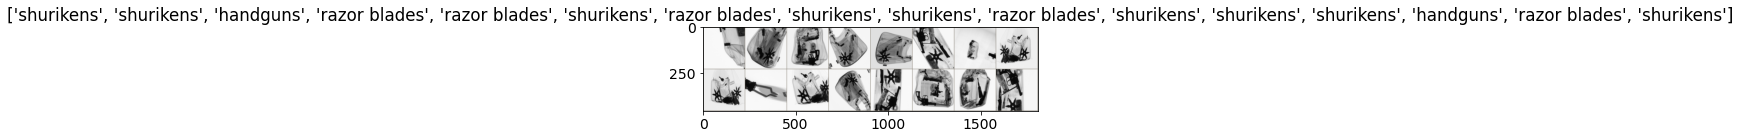

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)
print(inputs.shape)
imshow(out, title=[CLASSES[x] for x in classes])


# **Fine Tuning AlexNet**

In [16]:
model = models.alexnet(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

**Freeze Early layers**

In [0]:
for param in model.parameters():
    param.requires_grad = False
    

**Add layers for trasnfer learning**

In [18]:
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, NUM_CLASSES),                   
                      nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=3, bias=True)
    (1): LogSoftmax()
  )
)

**Check count of Trainable and Non-Trainable Parameters**

In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

57,016,131 total parameters.
12,291 training parameters.


In [0]:
# Move to gpu
model = model.to('cuda')

**Print Model summary**

In [21]:
from torchsummary import summary

summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 64, 55, 55]          23,296
              ReLU-2           [16, 64, 55, 55]               0
         MaxPool2d-3           [16, 64, 27, 27]               0
            Conv2d-4          [16, 192, 27, 27]         307,392
              ReLU-5          [16, 192, 27, 27]               0
         MaxPool2d-6          [16, 192, 13, 13]               0
            Conv2d-7          [16, 384, 13, 13]         663,936
              ReLU-8          [16, 384, 13, 13]               0
            Conv2d-9          [16, 256, 13, 13]         884,992
             ReLU-10          [16, 256, 13, 13]               0
           Conv2d-11          [16, 256, 13, 13]         590,080
             ReLU-12          [16, 256, 13, 13]               0
        MaxPool2d-13            [16, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [16, 25

## Training Network

In [22]:
save_file_name = 'alexnet-transfer-4.pt'
checkpoint_path = 'alexnet-transfer-4.pth'

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False


def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=5,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0
        running_corrects=0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
      
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                running_corrects += torch.sum(pred == target.data)

                # print(running_corrects,len(valid_loader.dataset))


                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average losses
            train_loss = train_loss / len(train_loader.sampler)
            valid_loss = valid_loss / len(valid_loader.sampler)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.sampler)
            valid_acc = valid_acc / len(valid_loader.sampler)
            epoch_acc = running_corrects.double() / len(valid_loader.sampler)
            

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                # print("epoch_acc",epoch_acc)
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    print("\n\n----------------\n\n")
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

Train on gpu: True
1 gpus detected.


In [0]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters())
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [26]:

model, history = train(
    model,
    criterion,
    optimizer_ft,
    train_loader,
    validation_loader,
    save_file_name=save_file_name,
    max_epochs_stop=4,
    n_epochs=10,
    print_every=1)

Model has been trained for: 7 epochs.


Epoch: 0 	Training Loss: 0.8738 	Validation Loss: 0.8121
		Training Accuracy: 71.30%	 Validation Accuracy: 74.33%

Best epoch: 0 with loss: 0.81 and acc: 74.33%


ZeroDivisionError: ignored

**Results**

In [27]:
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

NameError: ignored

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

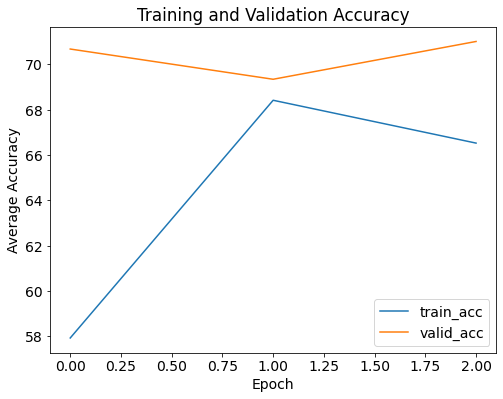

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [34]:
 for data, target in validation_loader:
     img= np.array(data.tolist()[0])
     print(img.)
     break;


(3, 224, 224)


## **Inference section**

In [0]:
def evaluateModel(model,data_loader):

    predictions = []
    truth = []

    with torch.no_grad():
        # Set to evaluation mode
        model.eval()

        # Validation loop
        for data, target in data_loader:
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Forward pass
            output = model(data)

            # Validation loss
            loss = criterion(output, target)
            # Calculate validation accuracy
            _, pred = torch.max(output, dim=1)
            predictions.extend(pred.tolist())
            truth.extend(target.tolist())
    return predictions,truth

      
      

In [0]:
pred,truth=evaluateModel(model,validation_loader)

In [0]:
def plotConfusionMatrix(mat):

    # Normalise
    normalized_mat = mat.astype('float') /mat.sum(axis=1)[:, np.newaxis]

    normalized_mat=np.around(normalized_mat*100)

    df_cm = pd.DataFrame(mat,index=CLASSES,columns=CLASSES)
    # plt.figure(figsize=(10,7))
    sns.set(font_scale=0.8)  # for label size
    sns.heatmap(df_cm, annot=True,fmt='d', cbar=False)  # font size

    plt.show()
predictions=pred
accuracy = accuracy_score(truth,predictions)
confusion_mat=confusion_matrix(truth,predictions)
precsion, recall, f1_ccore, _ = precision_recall_fscore_support(truth, predictions)
print("Total Accuracy :",round(accuracy*100,2))
print("Precision :", (precsion*100))
print("Recall :",(recall*100))
print("Handguns Accuracy :", round(f1_ccore[0]*100,2))
print("razor_blades Accuracy :",round(f1_ccore[1]*100,2))
print("shurikens Accuracy :", round(f1_ccore[2]*100,2))

plotConfusionMatrix(confusion_mat)


NameError: ignored

In [0]:


from math import sqrt
def plot_images(images, cls_true, cls_pred=None):

    # Create figure with 3x3 sub-plots.
    count = len(images)
    fig, axes = plt.subplots(int(sqrt(count)), int(sqrt(count)))
#     fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        img = images[i]
        img = np.moveaxis(img,0,-1)   
        ax.imshow(img[:,:,0],cmap='gray')


        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


def testRandom(model,data_loader,count =4):
    idx=np.random.randint(0,batch_size,count)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
        
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            img_list= np.array(inputs.tolist())[idx]
            predicted_labels=np.array(preds.tolist())[idx]
            true_labels = np.array(labels.tolist())[idx]
          
            break;
 
    # print(imgs.shape)
    # print(preds)
    # print(labels)
   
    
    plot_images(img_list,[CLASSES[x] for x in true_labels],[CLASSES[x] for x in predicted_labels])


   


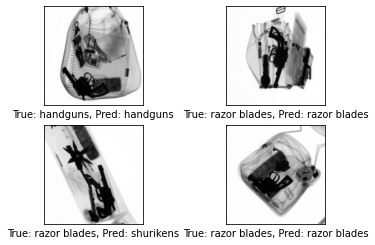

In [94]:
testRandom(model,validation_loader)